In [8]:
import numpy as np
import random
from PIL import Image
import depth_pro
import matplotlib
import matplotlib.pyplot as plt
import pyvista as pv

In [2]:
# Load model and preprocessing transform
model, transform = depth_pro.create_model_and_transforms()
model.eval()

# Load and preprocess an image.
image_path = "../../../test_images/forest_with_road.jpeg"
image, _, f_px = depth_pro.load_rgb(image_path)
image = transform(image)

# Run inference.
prediction = model.infer(image, f_px=f_px)
depth = prediction["depth"]  # Depth in [m].
focallength_px = prediction["focallength_px"]  # Focal length in pixels.

/home/exjobb/exjobb/eval_models/depth_pro/ml-depth-pro/src/depth_pro/depth_pro.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(config.checkpoin

torch.Size([142, 355])


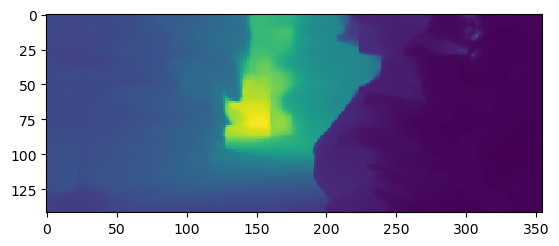

In [7]:
print(depth.shape)
from matplotlib import pyplot as plt
plt.imshow(depth, interpolation='nearest')
plt.show()

In [72]:
pv.set_plot_theme("document")

# Create a new camera
camera = pv.Camera()
near_range = 0.6
far_range = 0.8
camera.clipping_range = (near_range, far_range)

# Set the position of the drawn camera
camera.position = (1, 0, 0)  # Change this to the desired position
camera.focal_point = (0, 0, 0)  # The point the camera is looking at

# Calculate direction
unit_vector = np.array(camera.direction) / np.linalg.norm(
    np.array([camera.focal_point]) - np.array([camera.position])
)

# Create frustum for the drawn camera
frustum = camera.view_frustum(1.0)

position = camera.position
focal_point = camera.focal_point
line = pv.Line(position, focal_point)


# Initialize the plotter
pl = pv.Plotter()
pl.add_text("3D projection")
pl.add_mesh(frustum, style="wireframe")  # Draw the frustum of the camera
pl.add_mesh(line, color="b")            # Draw a line from the camera to the focal point
pl.add_point_labels(
    [
        position,
        camera.position + unit_vector * near_range,
        camera.position + unit_vector * far_range,
        focal_point,
    ],
    ["Camera Position", "Near Clipping Plane", "Far Clipping Plane", "Focal Point"],
    margin=0,
    fill_shape=False,
    font_size=14,
    shape_color="white",
    point_color="red",
    text_color="black",
)

# Change the viewing camera (the camera you use to view the scene)
pl.camera.position = (1, 1, 1)
pl.camera.focal_point = (0, 0, 0)
pl.camera.up = (0.0, 0.0, 1.0)
pl.camera.zoom(0.5)

# ----------------------------------------

# Create plane of the image
camera_center=np.array([1,0,0])
focal_point=np.array([0,0,0])
v=focal_point-camera_center # dir vector
v_norm=v/np.linalg.norm(v)
distance=near_range
Pc = camera_center + distance*v_norm

# Some random vector to start with cross product (is not used in final)
if v_norm[0] == 0 and v_norm[1] == 0:  # If v is along the Z-axis
    w = np.array([1, 0, 0])
else:
    w = np.array([0, 0, 1])

# Step 2: Compute the first orthogonal vector
u1 = np.cross(v_norm, w)
u1 = u1 / np.linalg.norm(u1)  # Normalize

# Step 3: Compute the second orthogonal vector
u2 = np.cross(v_norm, u1)
u2 = u2 / np.linalg.norm(u2)  # Normalize

# Generate points on the plane
# Parametrize the plane using the two basis vectors
n_points_h = depth.shape[0]
n_points_w = depth.shape[1]
d=0.001
dist_w=  depth.shape[1]*d
dist_h= depth.shape[0]*d

alphas = np.linspace(-dist_w, dist_w, n_points_w)  # Parameter for u1
betas = np.linspace(-dist_h, dist_h, n_points_h)   # Parameter for u2
plane_points = [
    Pc + alpha * u1 + beta * u2
    for alpha in alphas
    for beta in betas
]

np_plane_points=np.array(plane_points)
camera_center_repeated = np.tile(camera_center, (np_plane_points.shape[0], 1))
vectors_to_plane = np_plane_points - camera_center_repeated
vector_magnitudes = np.linalg.norm(vectors_to_plane, axis=1, keepdims=True)  # Compute magnitudes
normalized_vectors = vectors_to_plane / vector_magnitudes
desired_length = 1
scaled_vectors = normalized_vectors * desired_length
points_at_distance = camera_center + scaled_vectors

#plane_points = np.array(plane_points)
plane_points_2d=normalized_vectors.reshape(depth.shape[1], depth.shape[0], 3)
plane_points_2d=np.transpose(plane_points_2d, axes=(1, 2, 0))
#np_depth=np.array(depth)
depth_expanded = np.array(depth.unsqueeze(-1))
depth_points = plane_points_2d * depth_expanded
print(depth.shape)
print(plane_points_2d.shape)
print(depth_points.shape)
flatten_points=depth_points.reshape(depth.shape[0] * depth.shape[1], 3)
print(flatten_points[0:10])

pl.add_points(flatten_points, color="blue", render_points_as_spheres=True, point_size=5)
#pl.add_points(points_at_distance, color="blue", render_points_as_spheres=True, point_size=5)


pl.add_arrows(np.array([1,0,0]),np.array([-1,0,0]), mag=0.2)
pl.show()


ValueError: operands could not be broadcast together with shapes (142,3,355) (142,355,1) 

A view with name (P_0x7b7baffcf490_2) is already registered
 => returning previous one


Widget(value='<iframe src="http://localhost:35849/index.html?ui=P_0x7b7baffcf490_2&reconnect=auto" class="pyvi…